In [72]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Image processing with scikit-image

<img src="files/img_proc_stack.svg"/>

- [ndimage docs](http://docs.scipy.org/doc/scipy/reference/ndimage.html)

In [73]:
from scipy import ndimage as ndi
ndi?

## Counting grains and bubbles

This Scanning Element Microscopy image shows a glass sample
(light gray matrix) with some bubbles (black) and unmolten
sand grains (dark gray). We wish to determine the fraction
of the sample covered by these three phases,
and to estimate the number of sand grains and bubbles,
their average sizes, etc.

### Loading the slide

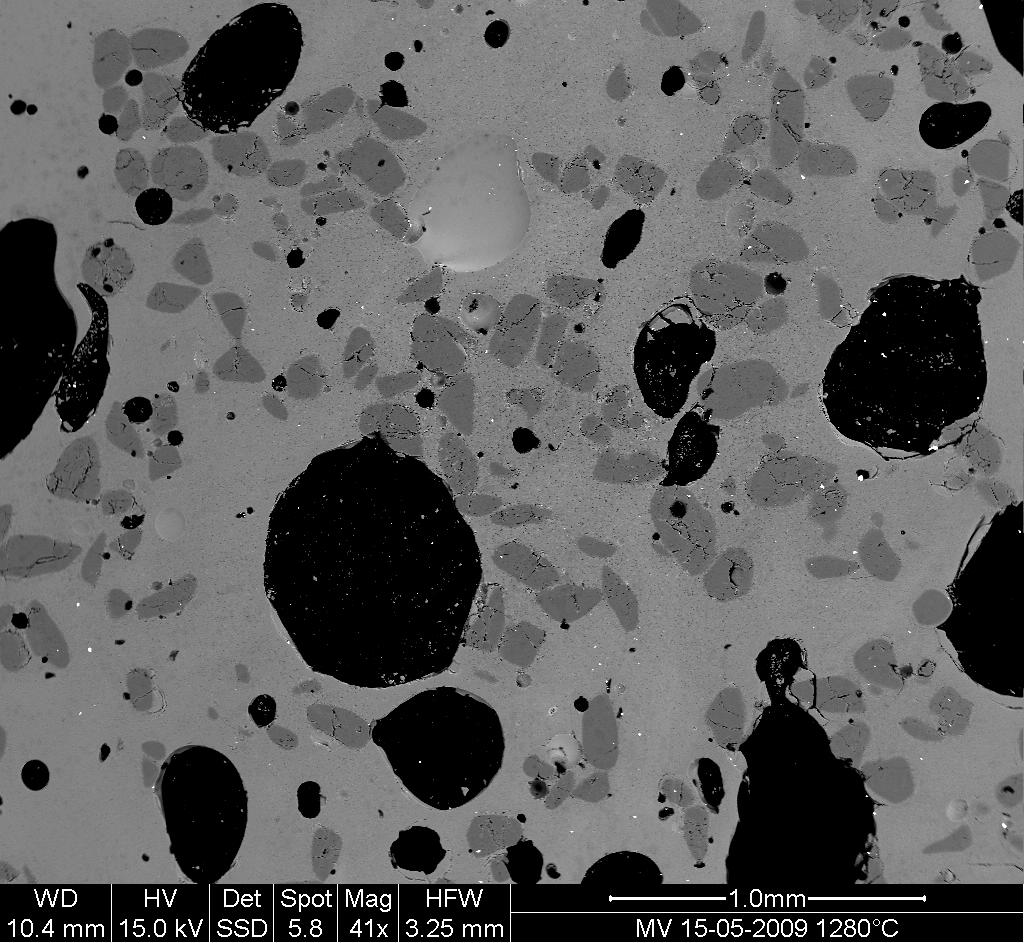

In [74]:
from IPython.display import Image
Image( 'bubbles.jpg')

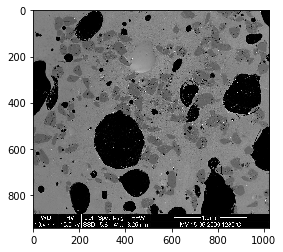

In [75]:
#img = np.flipud(plt.imread('bubbles.jpg'))
img = plt.imread('bubbles.jpg')
plt.imshow(img, cmap=plt.cm.gray);

### Remove banner

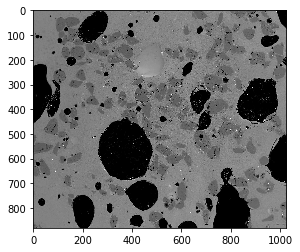

In [76]:
img_clean = img[:880, :]
plt.imshow(img_clean, cmap=plt.cm.gray);

### Filter to get rid of speckles

In [82]:
img_med.min(), img_med.max(), img.dtype

(0, 255, dtype('uint8'))

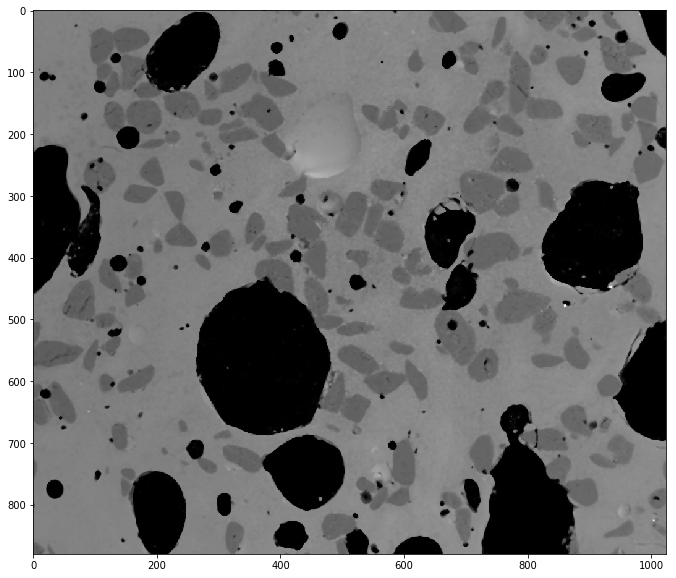

In [79]:
img_med = ndi.median_filter(img_clean, size=5)

f, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(img_med, cmap=plt.cm.gray);

### Find threshold values

In [ ]:
# Don't do this
# plt.hist(img_med, bins=40, range=(0, 150));

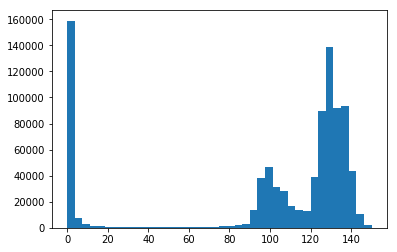

In [83]:
plt.hist(img_med.ravel(), bins=40, range=(0, 150));

### Separate layers by thresholding

In [87]:
x = np.arange(12) 
print(x)
mask = (x < 5)
print(mask)
print(x[mask])

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ True  True  True  True  True False False False False False False False]
[0 1 2 3 4]


In [88]:
bubbles = (img_med <= 50)
sand = (img_med > 50) & (img_med <= 120)
glass = (img_med > 120)

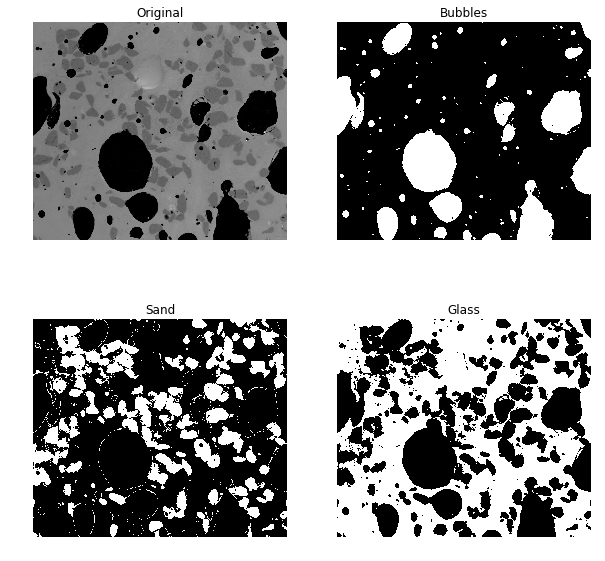

In [89]:
def plot_images(layers, labels=None, cmap=plt.cm.gray):
    f, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()
    
    if labels is None:
        labels = [''] * len(layers)
    
    for n, (name, image) in enumerate(zip(labels, layers)):
        ax = axes[n]
        ax.imshow(image, cmap=cmap)
        ax.set_title(name)
        ax.set_axis_off()
        
plot_images([img_med, bubbles, sand, glass],
            labels=('Original', 'Bubbles', 'Sand', 'Glass'));

### Visualise layers

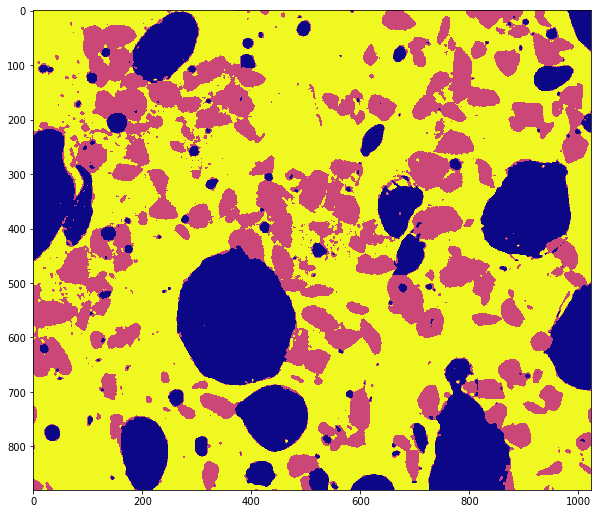

In [90]:
def layers_to_color(layers, background=(0, 0, 0)):
    if not all(layer.shape == layers[0].shape for layer in layers):
        raise ValueError("All input images must have the same shape")
    
    # Create new empty color image, filled with the background color
    all_layers = np.full((layers[0].shape[0],
                          layers[0].shape[1], 3), background, dtype=float)
    
    # Grab as many colors as layers from the "plasma" colormap
    N = len(layers)
    colors = plt.cm.plasma(np.linspace(0, 1, N, endpoint=True))[..., :3]

    # You shouldn't run this if layer isn't a mask
    # -- otherwise we get fancy indexing instead of masking
    if not all(layer.dtype == np.bool for layer in layers):
        raise ValueError("All input layers must be binary masks")
    
    for (color, layer) in zip(colors, layers):
        all_layers[layer] = color

    return all_layers


color_layers = layers_to_color([bubbles, sand, glass], background=(0, 1, 0))

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(color_layers);

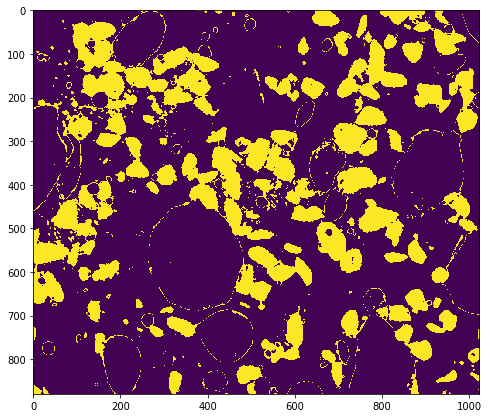

In [91]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(sand);

### Clean up shapes found

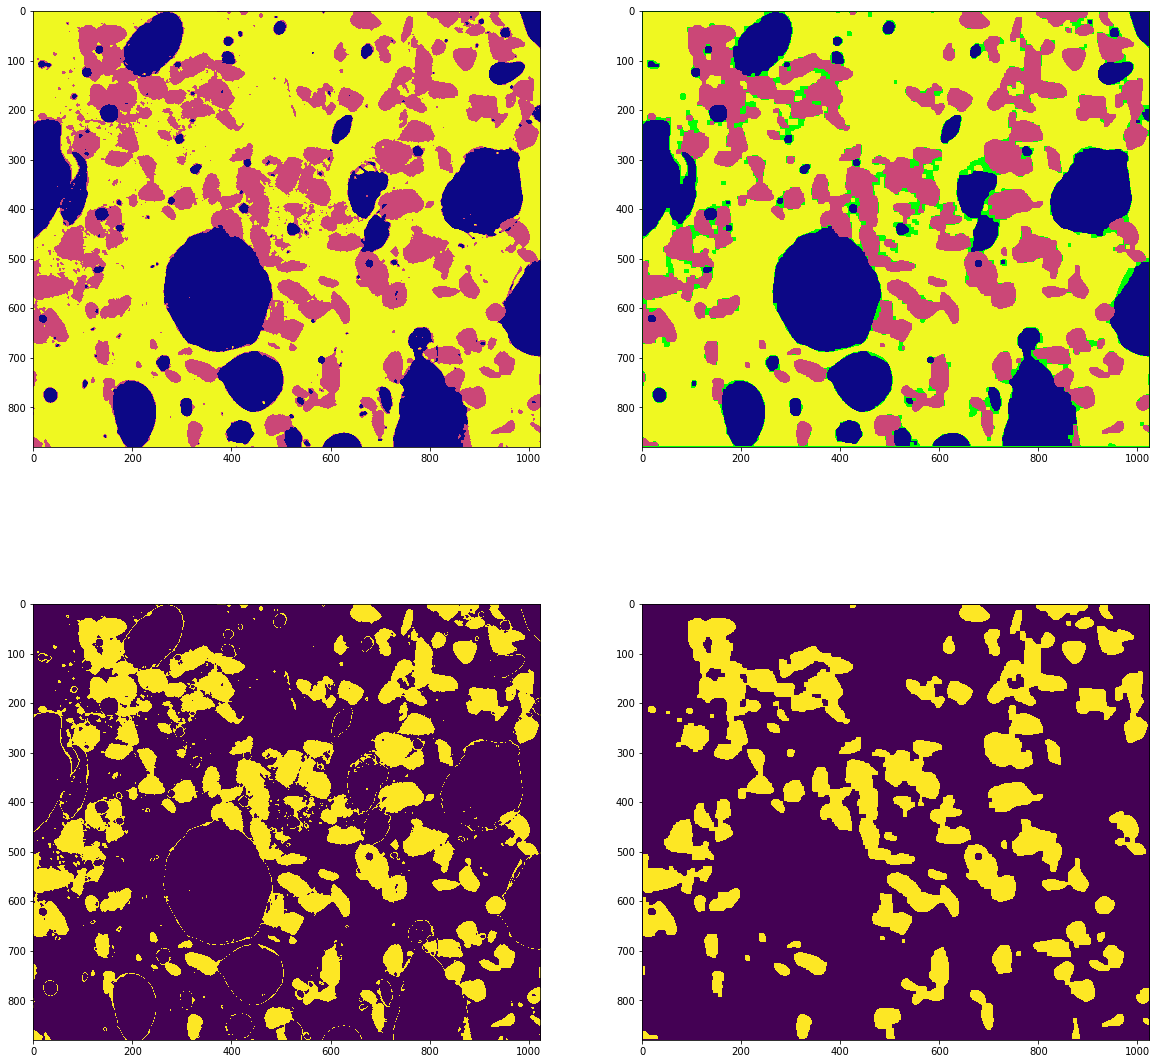

In [92]:
layers_denoised = [img.copy() for img in (bubbles, sand, glass)]

for img in layers_denoised:
    # Get rid of small artifacts, such as edge rings
    img[:] = ndi.binary_opening(img, np.ones((7, 7)))
    
    # Remove tiny holes
    img[:] = ndi.binary_closing(img, np.ones((7, 7)))
    
color_layers_denoised = layers_to_color(layers_denoised, background=(0, 1, 0))

f, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0, 0].imshow(color_layers)
axes[0, 1].imshow(color_layers_denoised)

axes[1, 0].imshow(sand)
axes[1, 1].imshow(layers_denoised[1]);

### Label connected components

Sand:
    1597 regions, µ = 136.7 σ = 1146.4 pixels, Σ = 218120
    
Bubbles:
    144 regions, µ = 1239.7 σ = 4742.7 pixels, Σ = 177276
    
Glass:
    113 regions, µ = 4514.8 σ = 47002.0 pixels, Σ = 505653
    


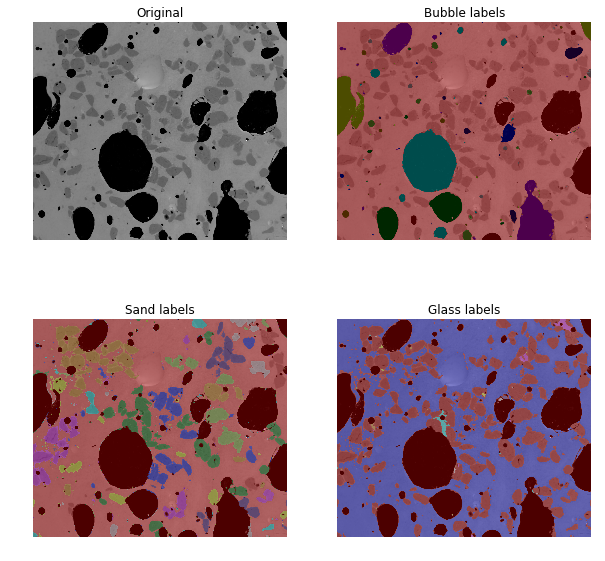

In [93]:
bubble_labels = np.zeros_like(bubbles, dtype=int)
sand_labels = np.zeros_like(sand, dtype=int)
glass_labels = np.zeros_like(glass, dtype=int)

for name, image, labels in [('Sand', sand, sand_labels),
                          ('Bubbles', bubbles, bubble_labels),
                          ('Glass', glass, glass_labels)]:
    
    labels[:], count = ndi.label(image)    
    
    obj_areas = [np.sum(labels == i) \
                 for i in range(1, labels.max())]
    µ = np.mean(obj_areas)
    σ = np.std(obj_areas)
    total = np.sum(obj_areas)
    
    print(f'''{name}:
    {count} regions, µ = {µ:.1f} σ = {σ:.1f} pixels, Σ = {total:d}
    ''')


from skimage.color import label2rgb
#import mark_boundaries
    
plot_images([img_med] + 
            [label2rgb(labels, image=img_med) for labels in(bubble_labels, sand_labels, glass_labels)],
            labels=('Original', 'Bubble labels', 'Sand labels', 'Glass labels'));

In [94]:
from skimage import measure

for name, image, labels in [('Sand', sand, sand_labels),
                          ('Bubbles', bubbles, bubble_labels),
                          ('Glass', glass, glass_labels)]:
        
        # Approximates areas more accurately
        
        regions = measure.regionprops(labels)from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

im = img_as_float(data.coins())

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()
        areas = [r.area for r in regions]
        
        print('µ = ', np.mean(areas))

µ =  136.5817157169693
µ =  1231.1180555555557
µ =  4475.380530973452


/home/stefan/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


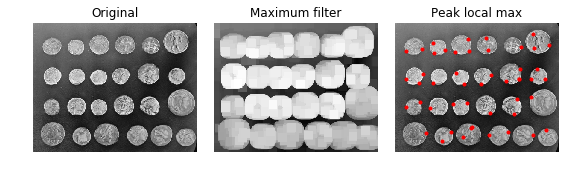

In [95]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

im = img_as_float(data.coins())

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

<img src="files/skimage_logo.png" style="float: left;"/>
<div style="clear: both;">

- [Homepage](http://skimage.org)
- [Documentation](http://scikits-image.org/docs/dev/)
- [Gallery](http://scikits-image.org/docs/dev/auto_examples/index.html)

In [ ]:
# %load http://scikit-image.org/docs/dev/_downloads/plot_blob.py


### Gallery example

 Paste any gallery example, such as http://scikit-image.org/docs/dev/_downloads/plot_equalize.py

### File input/output

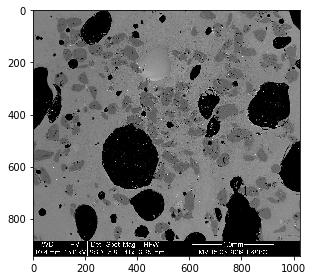

In [96]:
from skimage import io

img = io.imread('bubbles.jpg')
io.imshow(img);  # or plt.imshow(img) --- images are simply numpy arrays

### Jupyter widgets (simple image browser)

#### Install widgets as follows:

With conda:

```
conda install -c conda-forge ipywidgets
```

With pip, at the terminal, with the correct virtual environment enabled:

```
pip install ipywidgets
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

In [97]:
from skimage.io import ImageCollection

In [98]:
import skimage
skimage.data_dir

'/home/stefan/src/scikit-image/skimage/data'

In [99]:
%ls /home/stefan/src/scikit-image/skimage/data

astronaut_GRAY_hog_L1.npy      green_palette.png
astronaut_GRAY_hog_L2-Hys.npy  horse.png
astronaut.png                  hubble_deep_field.jpg
_binary_blobs.py               ihc.png
_blobs_3d_fiji_skeleton.tif    __init__.py
block.png                      lfw_subset.npy
brick.png                      logo.png
bw_text.png                    moon.png
bw_text_skeleton.npy           motorcycle_disp.npz
camera.png                     motorcycle_left.png
checker_bilevel.png            motorcycle_right.png
chelsea.png                    mssim_matlab_output.npz
chessboard_GRAY.png            multi.fits
chessboard_GRAY_U16B.tif       multipage_rgb.tif
chessboard_GRAY_U16.tif        multipage.tif
chessboard_GRAY_U8.npy         no_time_for_that_tiny.gif
chessboard_GRAY_U8.npz         orb_descriptor_positions.txt
chessboard_RGB.png             page.png
chessboard_RGB_U8.npy          palette_color.png
chessboard_RGB_U8.npz          palette_gray.png
clock_motion.png               phantom.png
coffee.

In [100]:
ic = ImageCollection(skimage.data_dir + '/*.png')
len(ic)

28

In [107]:
%matplotlib inline
from ipywidgets import interact

@interact(t0=(0, 255), t1=(0, 255))
def gallery(t0=0, t1=255):
    plt.imshow((img_med < t1) & (img_med > t0), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=0, description='t0', max=255), IntSlider(value=255, description='t1', max=255), Output()), _dom_classes=('widget-interact',))

In [101]:
%matplotlib inline
from ipywidgets import interact

@interact(n=(0, len(ic)))
def gallery(n=0):
    plt.imshow(ic[n], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=0, description='n', max=28), Output()), _dom_classes=('widget-interact',))

In [108]:
from ipywidgets import interact
from skimage import color, data, filters

image = color.rgb2gray(data.hubble_deep_field())

@interact(sigma=(0.1, 10, 0.1), )
def filter_image(sigma=1):
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(
        filters.gaussian(image, sigma=sigma),
        cmap='gray'
    )
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='sigma', max=10.0, min=0.1), Output()), _dom_classes=('widget-interact',))

Here, we illustrate how to load FITS files.  You'll need `astropy` installed to try this:

In [109]:
from astropy.io import fits
fits_image = fits.open('ngc7635_041008_15i75m_L.FIT')
fits_image.info()

Filename: ngc7635_041008_15i75m_L.FIT
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (4008, 2672)   int16 (rescales to uint16)   


In [110]:
ngc7635 = fits_image[0].data

If you don't have `astropy` installed, use the following instead:

In [ ]:
# from skimage import img_as_uint
# from skimage import color
#
# ngc7635 = img_as_uint(color.rgb2gray(data.hubble_deep_field()))
# 
# plt.imshow(ngc7635, cmap='gray')

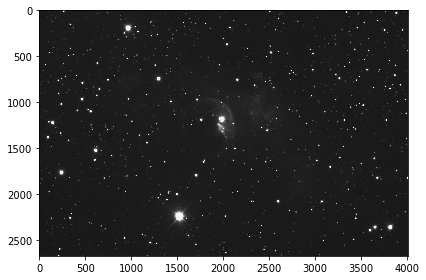

In [111]:
io.imshow(ngc7635);

### Data types and ranges

[Data-type documentation](http://scikits-image.org/docs/dev/user_guide/data_types.html)

In [112]:
print(ngc7635.dtype)
print(ngc7635.min(), ngc7635.max())

uint16
100 65535


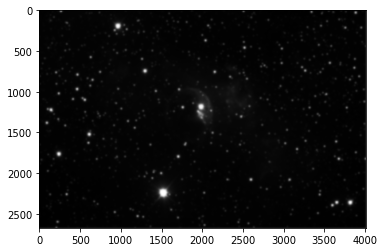

In [113]:
from skimage import filters
out = filters.gaussian(ngc7635, sigma=10)

plt.imshow(out, cmap='gray');

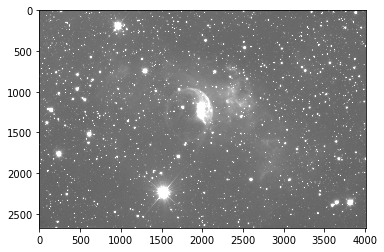

In [114]:
from skimage import exposure
ngc7635_ = exposure.rescale_intensity(ngc7635, in_range=(0, 16000))
plt.imshow(ngc7635_, cmap='gray');

(0.006240939955748837, 1.0)

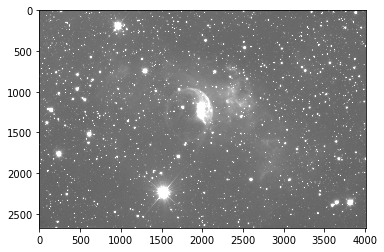

In [119]:
fimg = img_as_float(ngc7635_)
plt.imshow(fimg, cmap='gray')
fimg.min(), fimg.max()

In [115]:
# Conversion functions
from skimage import img_as_float, img_as_int, img_as_ubyte

print(img_as_float(ngc7635_).max())
print(img_as_int(ngc7635_).max())
print(img_as_ubyte(ngc7635_).max())

1.0
32767
255


/home/stefan/src/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from uint16 to int16
  .format(dtypeobj_in, dtypeobj_out))
/home/stefan/src/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


### Obtaining test data

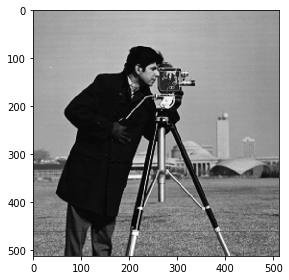

In [120]:
from skimage import data
io.imshow(data.camera());

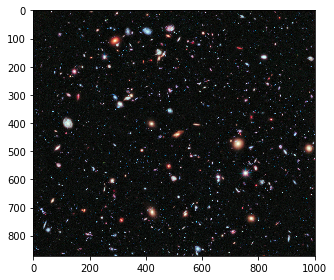

In [121]:
io.imshow(data.hubble_deep_field());

### Constructing a pipeline

In ``skimage``, functions should take any data-type image as input, but produce whichever data-type
output it can generate most efficiently.  This means that you can always build pipelines (i.e. apply an skimage function to the output of another).

E.g., let's combine denoising and edge detection:

- http://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_tv_bregman
- http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.canny

In [122]:
from skimage import feature, restoration

def pipeline(image):
   return feature.canny(
       restoration.denoise_tv_bregman(image, weight=1),
       sigma=5
   )

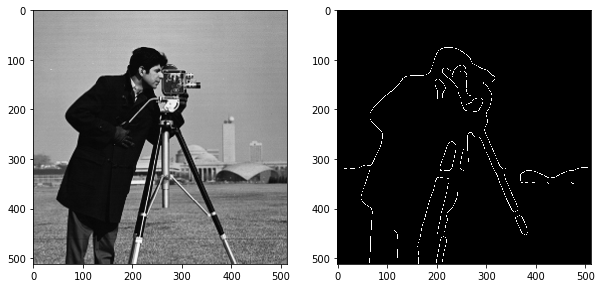

In [123]:
img = data.camera()

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(img, cmap='gray')
ax1.imshow(pipeline(img), cmap='gray');

#### A slightly cleaner pipeline

1. What are partial functions?
2. String together several partials to form a pipeline

In [ ]:
def my_fancy_function(a, b, c=5):
    return f"Hello, I got {a}, {b} and {c}"

In [124]:
my_fancy_function(1, 2, 3)

'Hello, I got 1, 2 and 3'

In [ ]:
from functools import partial

my_smaller_function = partial(my_fancy_function, b=3)

In [126]:
my_smaller_function(-1)

'Hello, I got -1, 3 and 5'

In [ ]:
def pipe(*funcs):
    """String together several functions and their outputs
    
    `pipe(f1, f2, f3)` returns a new function `f(data)`:
        
    data-->| f1 |-->| f2 |-->| f3 |-->out
    
    """
    def pipeline(data):
        for f in funcs:
            data = f(data)
        return data

    return pipeline

In [127]:
denoise = partial(restoration.denoise_tv_bregman, weight=1)
edge_detect = partial(feature.canny, sigma=5)

pipeline = pipe(denoise, edge_detect)

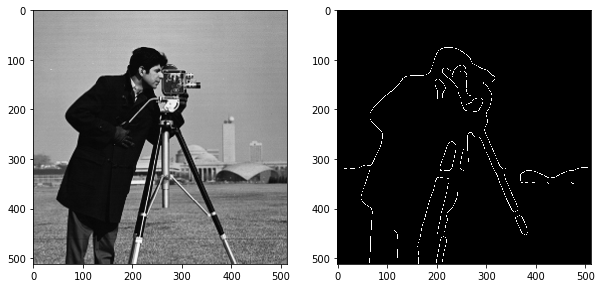

In [128]:
img = data.camera()
out = pipeline(img)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(img, cmap='gray')
ax1.imshow(out, cmap='gray');

For more such pipelining & functional programming tools, see http://toolz.readthedocs.io/en/latest/api.html

### Geometric Transformations

Note: for historic reasons, the geometric transformations module uses `xy` coordinates instead of `row-column`.

In [132]:
transform.SimilarityTransform?

Let's send a coordinate through the transformation by hand:
Origin maps to -> [[150.   0.]]
Coordinate [150, 0] maps back to -> [[-2.84217094e-14  0.00000000e+00]]


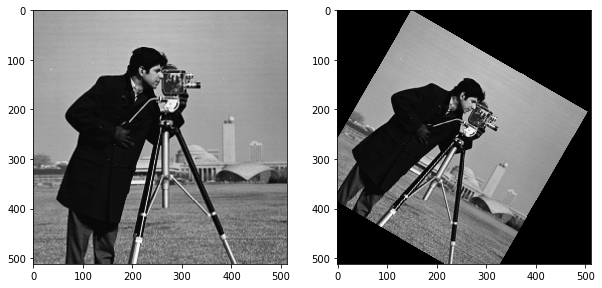

In [134]:
from skimage import transform

theta = np.deg2rad(30)
s = 0.8
tx, ty = 150, 0

tf = transform.SimilarityTransform(rotation=theta, translation=(tx, ty), scale=s)

img = data.camera()
out = transform.warp(img, tf.inverse)

print("Let's send a coordinate through the transformation by hand:")
print("Origin maps to ->", tf([0, 0]))
print("Coordinate [150, 0] maps back to ->", tf.inverse([150, 0]))

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(img, cmap=plt.cm.gray)
ax1.imshow(out, cmap=plt.cm.gray);

### Non-linear warping

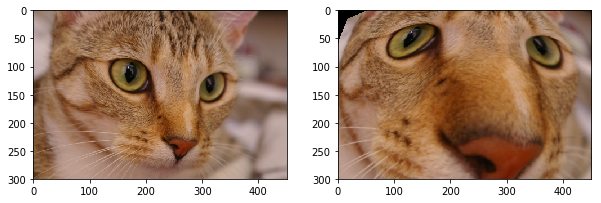

In [135]:
from skimage import transform

image = data.chelsea()

def fisheye(xy, p=2.3, k=2.1, R=0.95, center=None):
    if center is None:
        center = np.mean(xy, axis=0)
    xc, yc = (xy - center).T
    
    # Polar coordinates
    r = np.sqrt(xc**2 + yc**2)
    theta = np.arctan2(yc, xc)

    r = R * np.exp(r**(1/p) / k)

    return np.column_stack((
        r * np.cos(theta), r * np.sin(theta)
        )) + center 

out = transform.warp(image, fisheye,
                     map_args={'p': 2.3, 'center': (250, 230), 'R': 1})

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(image)
ax1.imshow(out);

### Block views and filtering

In [ ]:
from skimage.util import view_as_windows, view_as_blocks
img = data.camera()
img.shape

Construct rolling window over image:

In [ ]:
w = view_as_windows(img, window_shape=(20, 20))
print(w.shape)

In [ ]:
img_max = w.max(axis=2).max(axis=2)
print(img_max.shape)

In [ ]:
io.imshow(img_max);

The same can now be achieved using Dask: [demo](dask_ghosting.ipynb)

### Feature detection: histogram of gradients

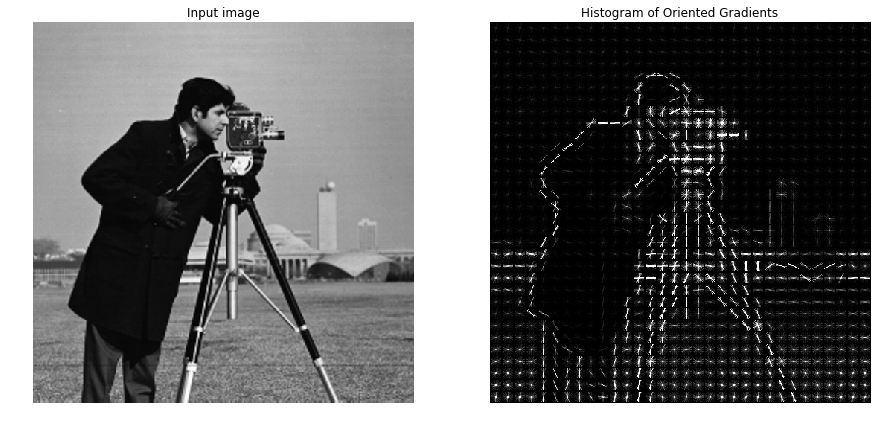

In [136]:
from skimage.feature import hog
from skimage import data, color, exposure

image = data.camera()

fd, hog_image = hog(image, orientations=16, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))

ax0.set_axis_off()
ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title('Input image')

ax1.set_axis_off()
ax1.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax1.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
%matplotlib

# Breakout

Please pick one of the following problems to work on.

## Image registration

Consider two satellite views of the same area:

<pre>
webreg_0.jpg webreg_1.jpg
</pre>

1. Load and display the images.
2. Find coordinates that correspond between these images.  The easiest way
   is probably outside the notebook, using `plt.ginput`.
3. Using these sets of corresponding coordinates, fit an affine transform:
   `skimage.transform.AffineTransform`.
4. Apply the transform and then overlay the two images.

Hints:

 - Look at ``skimage.transform``.
 - Use matplotlib's ``ginput`` to find point coordinates.

The process of aligning and combining images is known as "image registration".

For a much more detailed panoramic stitching example, see

https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb


## False-color image representation

Consider the provided image files:

<pre>
  m8_050507_26i26m_L.png  m8_050507_9i9m_B.png  m8_050507_9i9m_R.png
  m8_050507_5i75m_H.png   m8_050507_9i9m_G.png
</pre>

1. Load and display the individual inputs
2. Add the inputs together to form a single grey-level image `(L + H + R + G + B)`.  Displaying
   this image gives you an idea for all the information at your disposal.
3. Now, combine these images into a single color  image.  Apply denoising as
   as you see fit.  A real-world example pipeline is given here:

  http://www.mistisoftware.com/astronomy/Process_m8.htm

Hints:

 - These images are enormous--scale them down before playing around.
 - It may sometimes be easier to manipulate image colors in the Hue-Saturation-Value (HSV) colorspace.  Use `skimage.color.rgb2hsv` and `skimage.color.hsv2rgb`.
 - A colour image has dimensions ``(M, N, 3)`` for red, green and blue layers.
 - Bonus: to explore parameters, consider experimenting with Jupyter widget sliders.


[RANSAC lecture and breakout](ransac.ipynb)